# Data Cleaning

## Objectives
Our objectives for this notebook are as following:

- Prepare the data sets for further analysis.
- Load and inspect the data from Data collection 
- Correlation and PPS study.
- Data Cleaning.

## Inputs
- outputs/datasets/collection/HousePrice.csv

## Outputs
- outputs/datasets/cleaned/trainSet.csv
- outputs/datasets/cleaned/testSet.csv
- outputs/datasets/cleaned/cleanSet.csv

  
## Notes

- This projects relays on the guidelines provided in the walk through projects, and the lessons provided along the course provided by code institute (especially in the Predictive Analysis)

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir
print(os.listdir())  
print(os.listdir('/workspaces'))

['DataCleaning.ipynb', 'Housing_SalePrice_Study.ipynb', 'DataCollection.ipynb']
['Heritage-Housing', '.codespaces']


We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [5]:
os.chdir('/workspaces/Heritage-Housing/jupyter_notebooks')
print(os.getcwd())

/workspaces/Heritage-Housing/jupyter_notebooks


In [6]:
current_dir = os.getcwd()
current_dir

'/workspaces/Heritage-Housing/jupyter_notebooks'

# Load Data

In [8]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
from pandas_profiling import ProfileReport
from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer
from sklearn.pipeline import Pipeline

In [9]:

df = pd.read_csv(f"/workspaces/Heritage-Housing/outputs/datasets/collection/HousePrices.csv")
print(df.shape)

(1460, 22)


## Data Exploration

To begin, we'll explore the dataset by examining variable types, distributions, and any missing values or levels. We'll also assess the potential contribution of each variable in relation to the first business requirement.

Our first step is to identify the variables that contain missing values.

In [10]:
vars_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtExposure',
 'BsmtFinType1',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea']

Create a Pandas Profiling report that includes only the var_missing_data variable for analysis.

In [11]:
from ydata_profiling import ProfileReport
if vars_missing_data:
    profile = ProfileReport(df=df[vars_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Correlation and PPS Analysis

The following code cell is sourced from the Code Institute's Churnometer walkthrough project and generates two correlation heatmaps along with Predictive Power Score (PPS) charts.

Specifically:

- Correlation heatmaps help identify which features have strong linear relationships with each other and with the target variable (e.g. sale price).

- PPS (Predictive Power Score) charts go a step further by detecting non-linear and asymmetric relationships, revealing variables that are useful for prediction even if their correlation is weak or non-existent.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                        mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                        linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman", numeric_only=True)
    df_corr_pearson = df.corr(method="pearson", numeric_only=True)

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                    figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
        f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Calculate both the correlation matrix and the Predictive Power Score (PPS) to assess relationships between variables

In [42]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  462.0  0.064  0.111  0.0  0.0  0.0  0.088  0.702




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



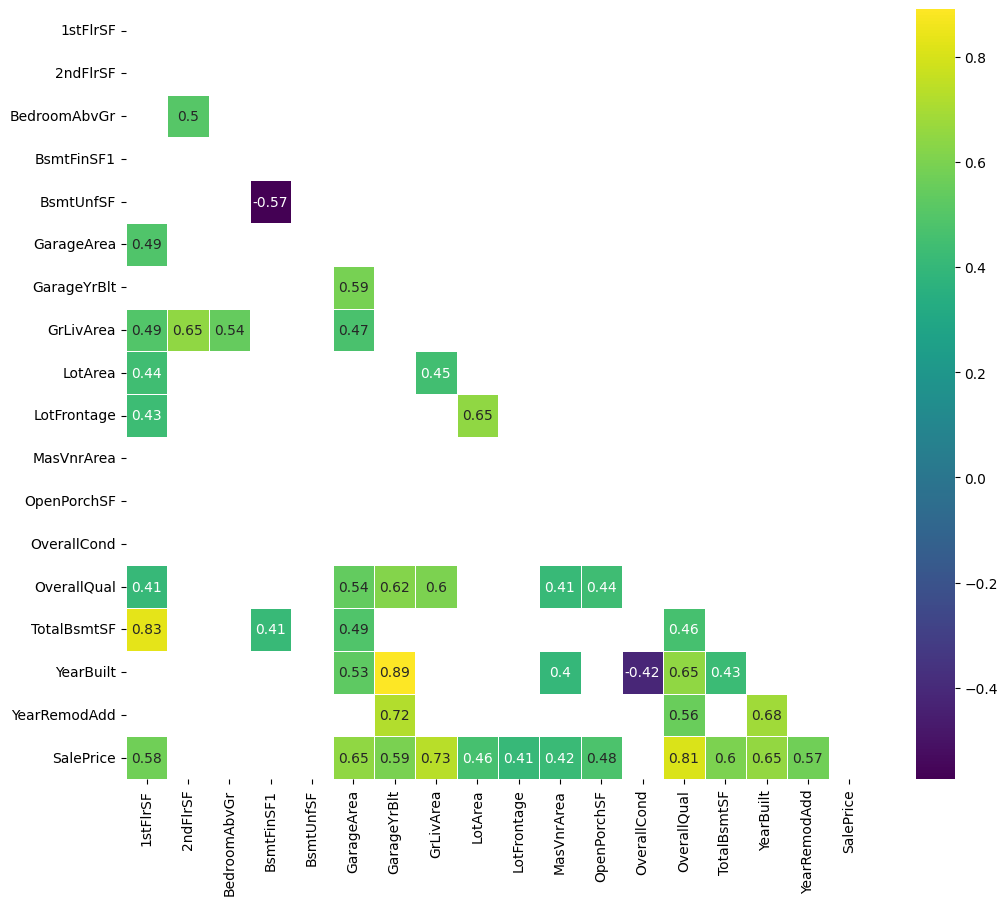

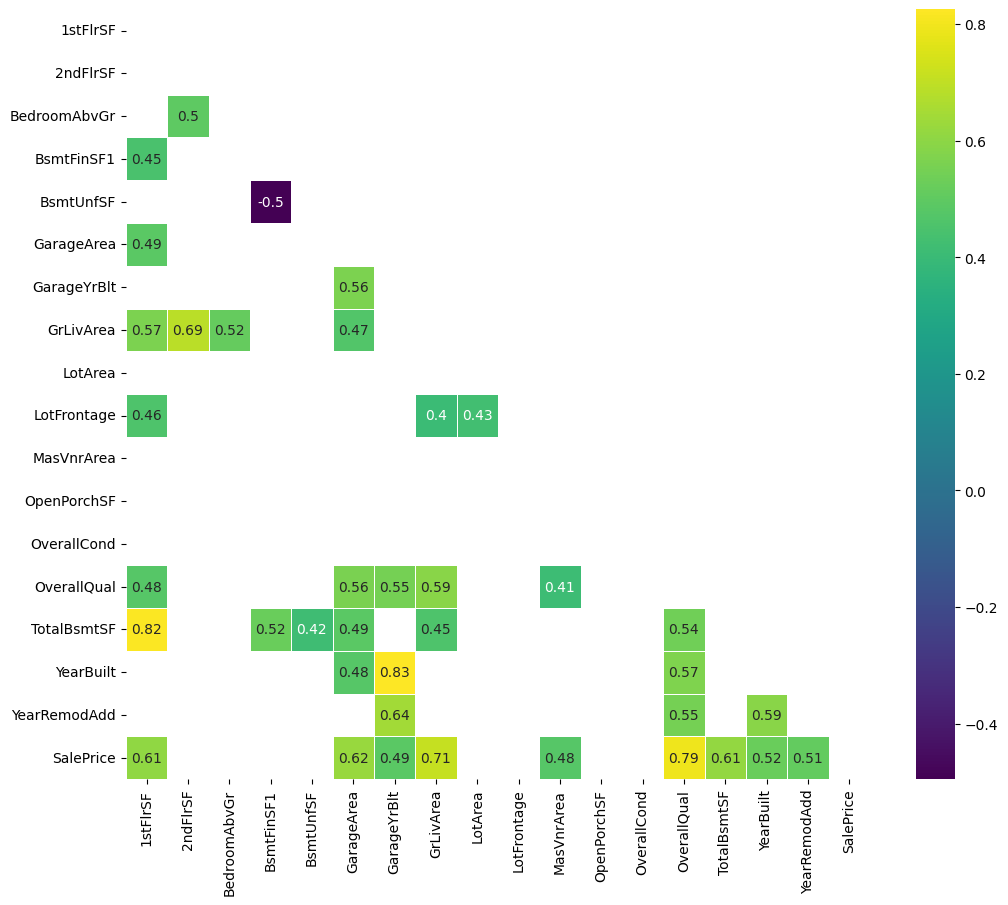

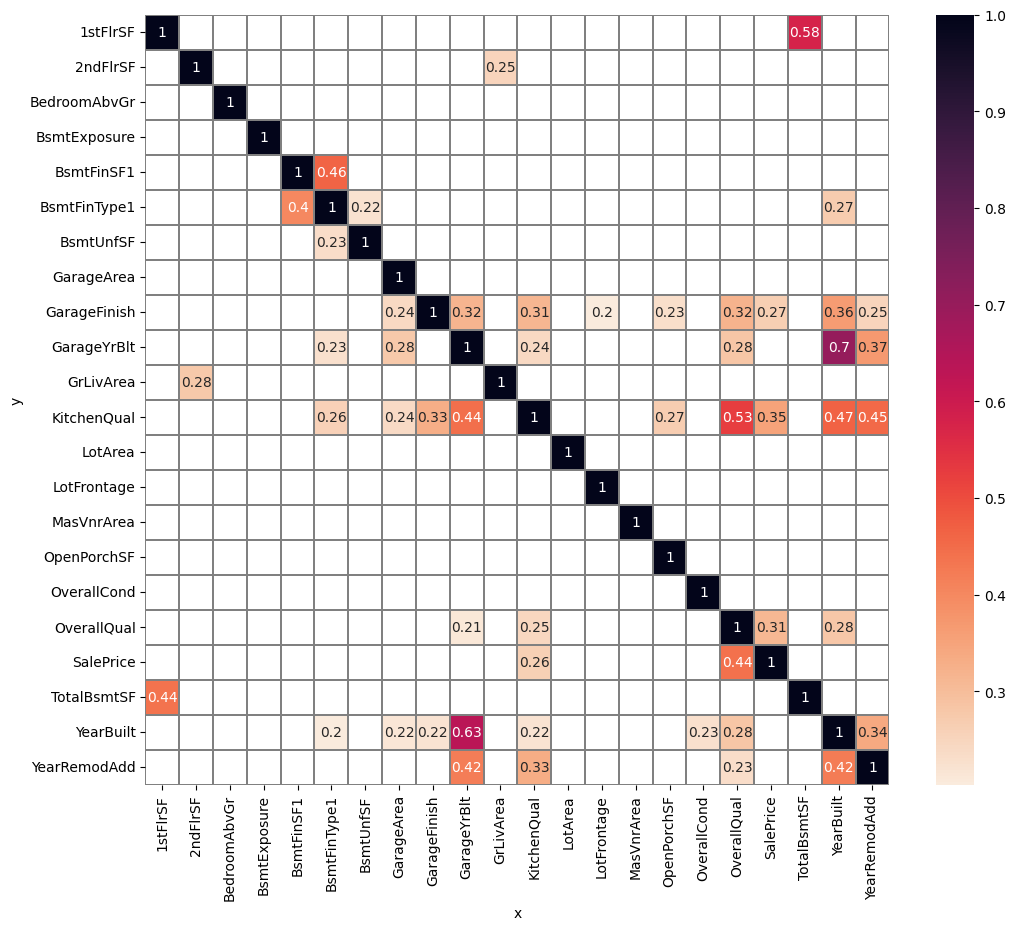

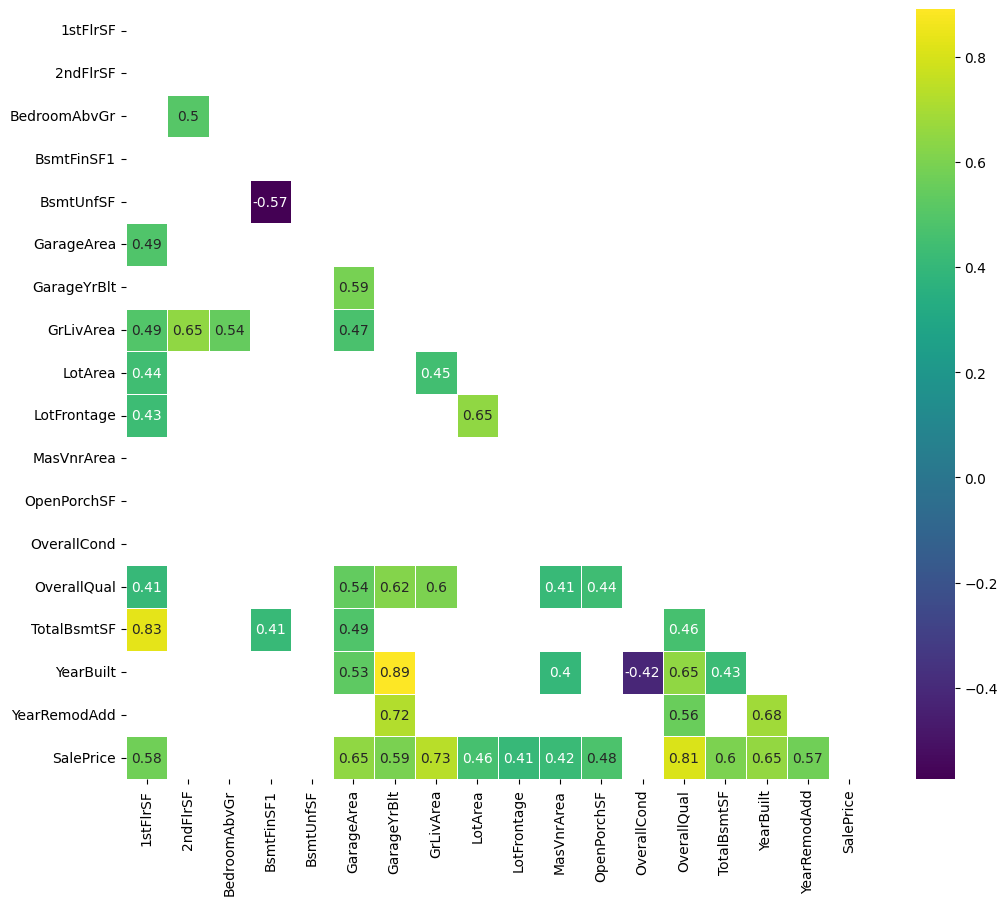

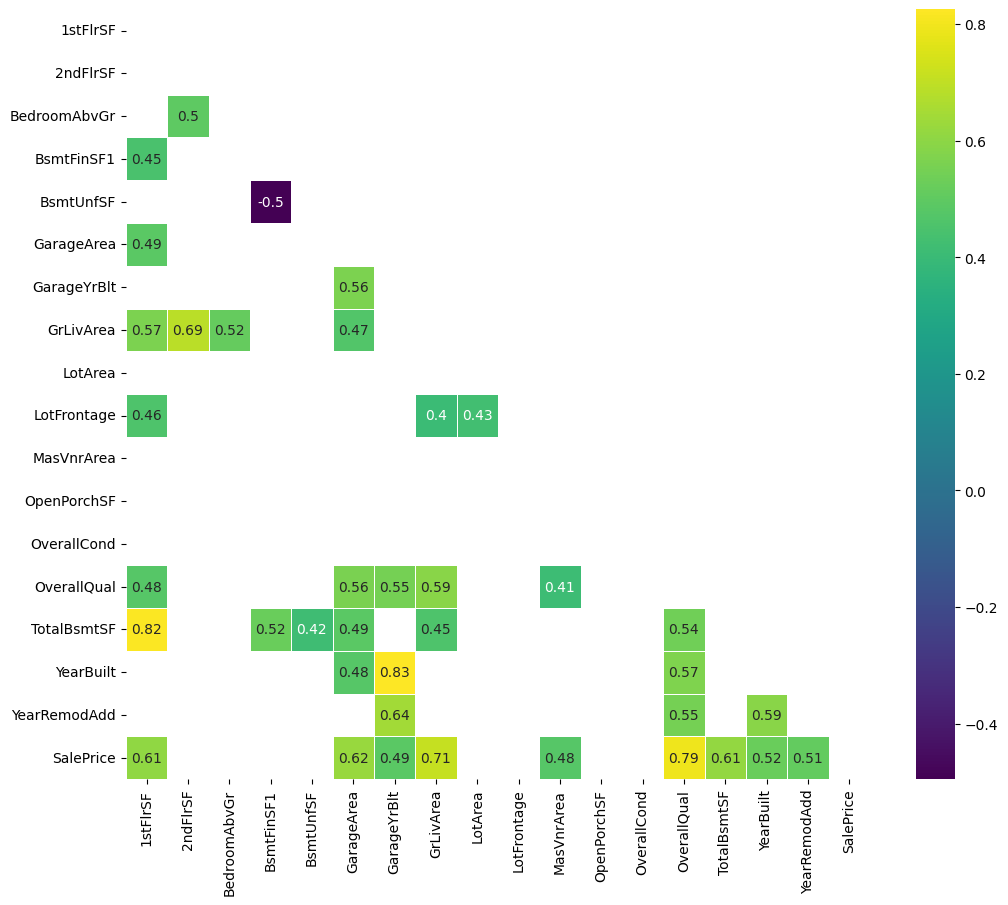

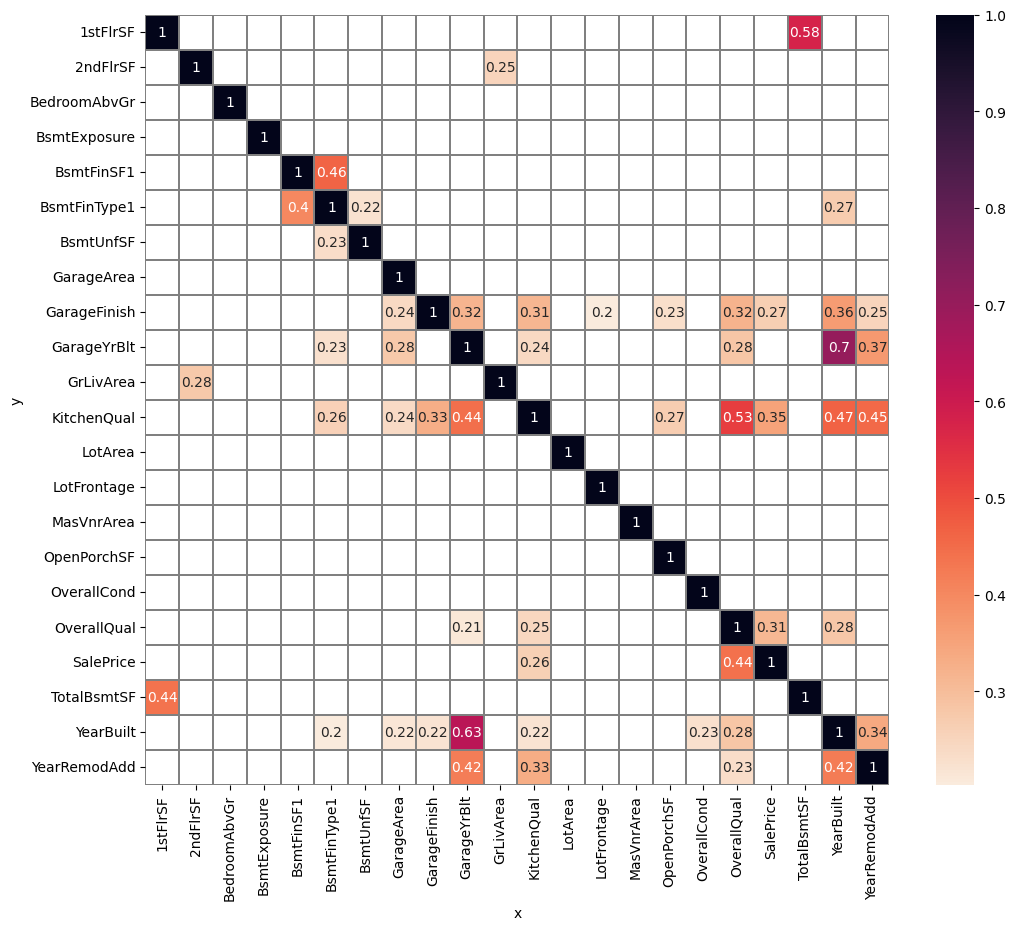

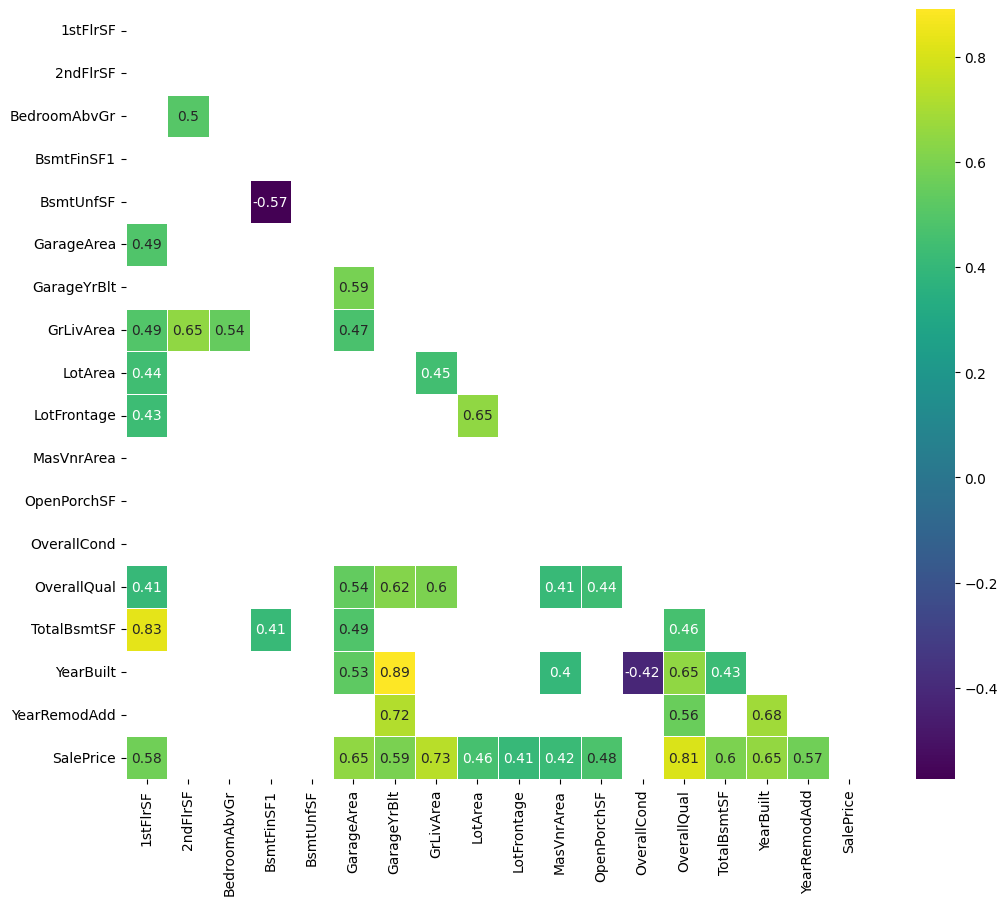

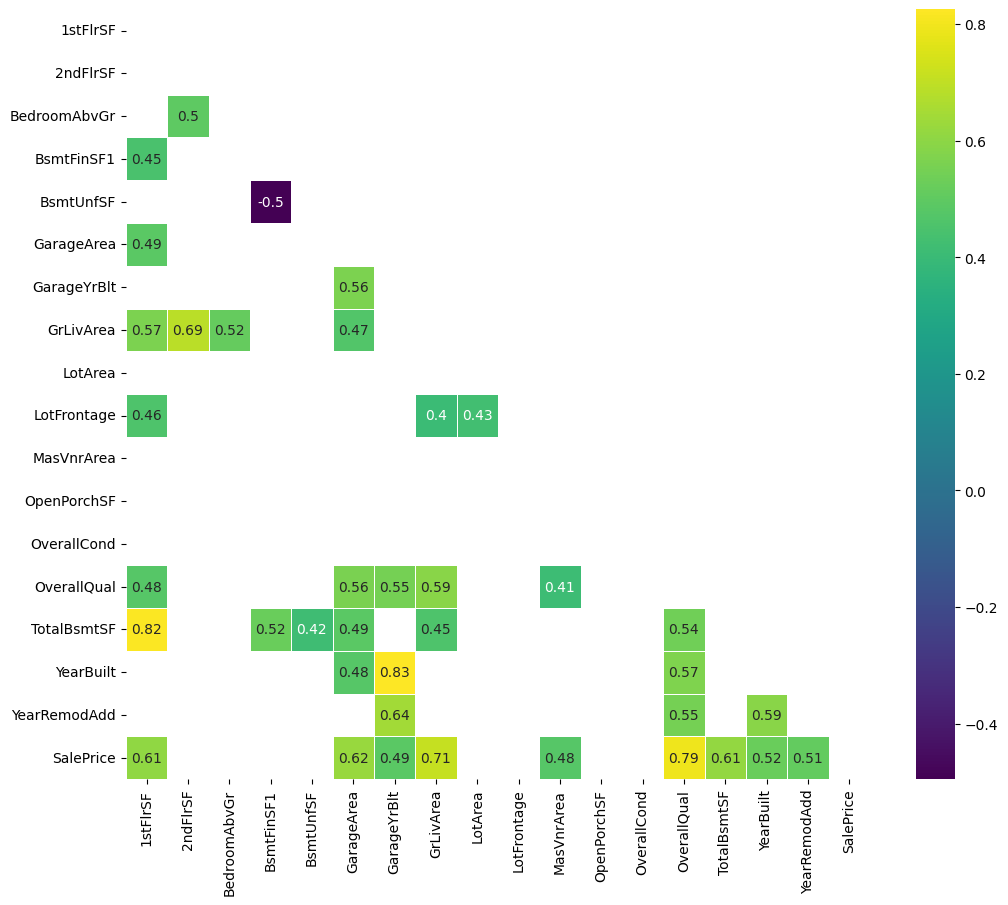

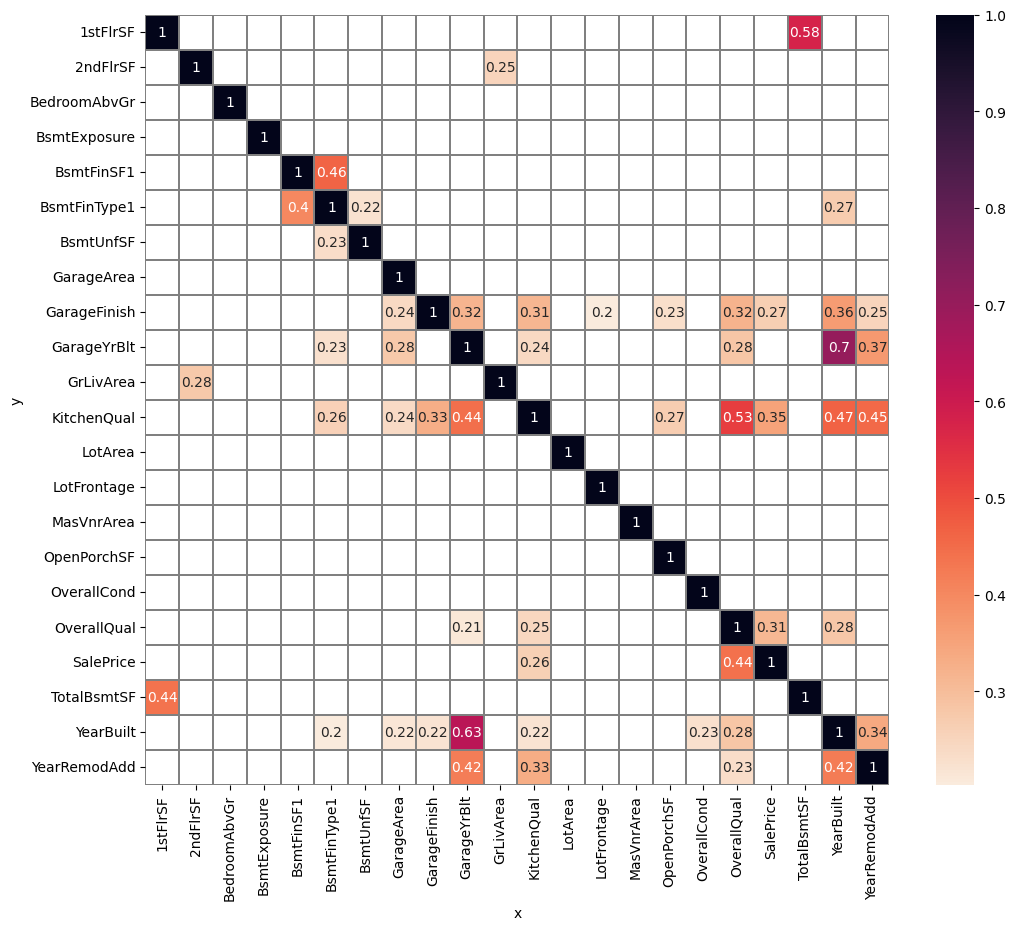

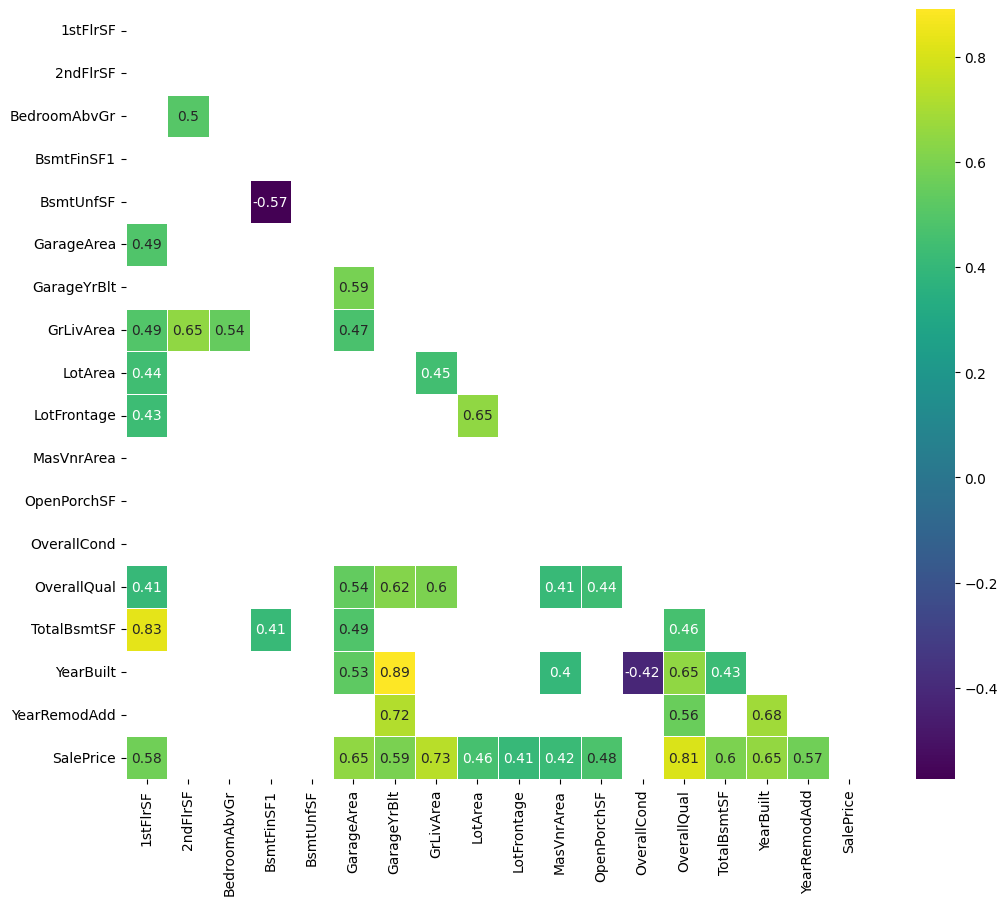



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



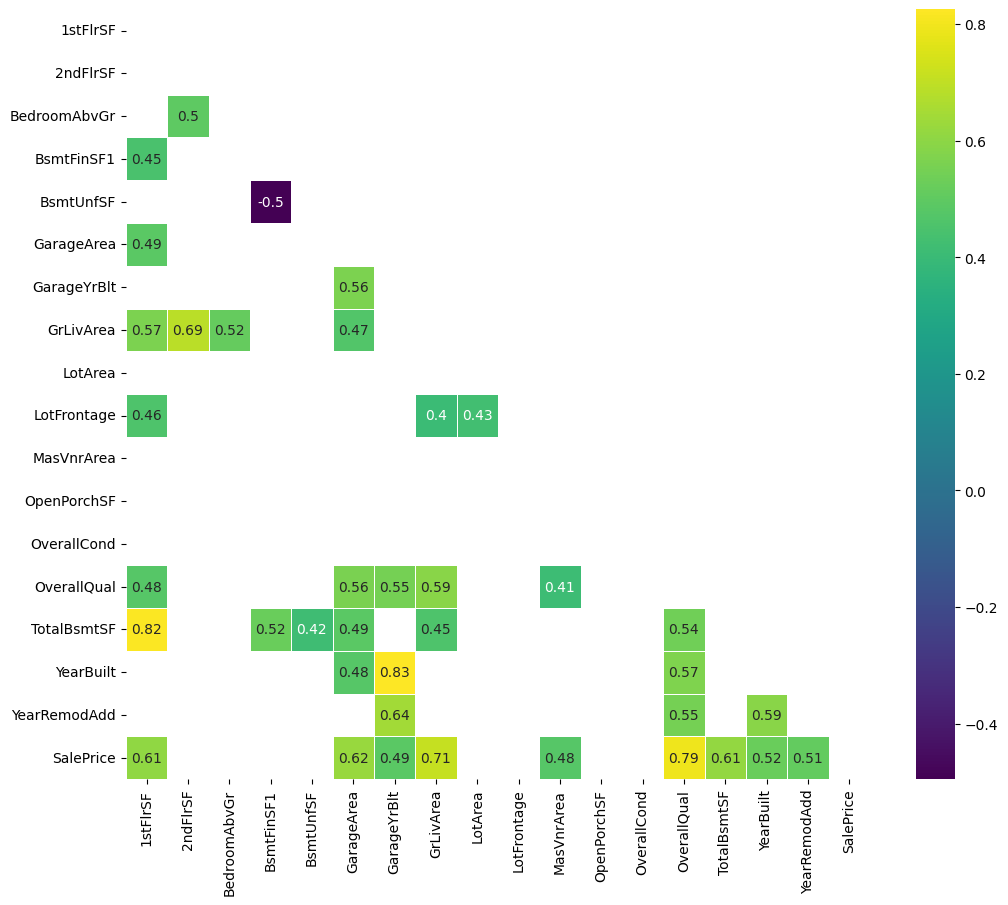



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



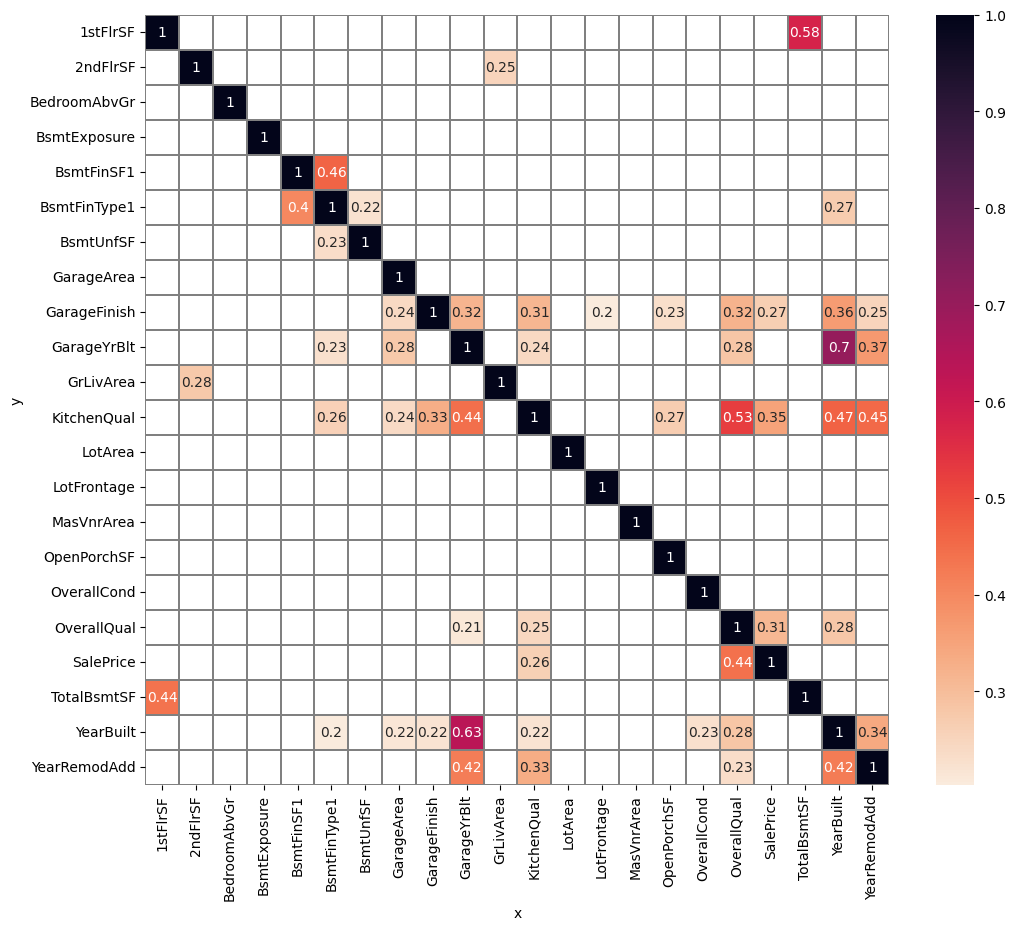

In [43]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

**Analysis and observations**

The correlation and PPS analyses highlight key predictors of house sale price.
1. OverallQual (Overall Quality) consistently emerged as the strongest predictor across all three measures: Pearson, Spearman, and PPS. 
2. Other top predictors include GrLivArea (above-ground living area), GarageArea, TotalBsmtSF, and YearBuilt, all showing strong positive correlations and moderate-to-high PPS scores. 

These variables exhibit both linear and monotonic relationships with SalePrice, indicating their importance for model development. Variables like KitchenQual also showed moderate predictive power, while others such as BsmtUnfSF, LotFrontage, and OpenPorchSF showed weaker or inconsistent relationships. 

## Data Cleaning

### Assessing Missing Data in the Dataset

We will use function to display missing data information in a structured DataFrame, including:

- The absolute number of missing values per column

- The percentage of missing values (relative level)

- The data type of each variable

This summary will help us better understand the extent of missing data and guide our cleaning strategy.

In [44]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100 , 2)
    df_missing_data = (pd.DataFrame(
                            data= {"RowsWithMissingData": missing_data_absolute,
                                    "PercentageOfDataset": missing_data_percentage,
                                    "DataType":df.dtypes}
                                    )
                        .sort_values(by=['PercentageOfDataset'],ascending=False)
                        .query("PercentageOfDataset > 0")
                        )

    return df_missing_data

EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
LotFrontage,259,17.74,float64
GarageFinish,235,16.10,object
BsmtFinType1,145,9.93,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
BsmtExposure,38,2.60,object
MasVnrArea,8,0.55,float64


We now have a clear understanding of the missing variables and their correlations, allowing us to make informed decisions on how to handle them.

- LotFrontage has 17.74% missing values, low correlation, and very low predictive power, so imputing with the median is sufficient. 

- GarageFinish is missing in 16.10% of entries but has moderate correlation and PPS, so filling with None or Unfinished.

- BsmtFinType1 has 9.93% missing data and moderate predictive value, so it's worth keeping and imputing with the either 'unf' or'unk'. 

- BedroomAbvGr has 6.78% missing values, weak correlation, and low PPS, but can be imputed with the 0 indicating no bedroom above grade.  

- 2ndFlrSF is 5.89% incomplete, weakly correlated, and has low predictive strength, imputiion with 0 indicated no second floor.

- GarageYrBlt has 5.55% missing values, moderate correlation and PPS, and can be imputed with median.

- BsmtExposure is missing in 2.60% of cases, has weak correlation and low PPS, however this is useful  and can be imputed with frequent caterogies. 

- MasVnrArea has minimal missing data (0.55%), low correlation, and very low PPS, making it a candidate for dropping. 

### Creating a backup for original data frame

Creating a copy of the DataFrame protects the original data, allowing you to experiment, prevent unintended changes, and refer back if needed — which helps ensure a clean, flexible, and reproducible workflow.

In [45]:
df_clean = df.copy()
print(df_clean.shape)

(1460, 22)


## Test and Train Set

Splitting the dataset into two parts is essential for building and evaluating a machine learning model. It ensures we can train the model on one portion of the data and evaluate its performance on unseen data using the other.

Using train_test_split to randomly split the DataFrame df into two parts:

- train_set: 80% of the data used to train the model

- test_set: 20% of the data used to test the model

In [46]:
from sklearn.model_selection import train_test_split
train_set, test_set, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"train_set shape: {train_set.shape} \ntest_set shape: {test_set.shape}")

train_set shape: (1168, 22) 
test_set shape: (292, 22)


In [47]:
EvaluateMissingData(train_set)

,RowsWithMissingData,PercentageOfDataset,DataType
LotFrontage,212,18.15,float64
GarageFinish,184,15.75,object
BsmtFinType1,114,9.76,object
BedroomAbvGr,80,6.85,float64
2ndFlrSF,60,5.14,float64
GarageYrBlt,58,4.97,float64
BsmtExposure,28,2.40,object
MasVnrArea,6,0.51,float64


## **Imputer/Optimizing Variables from evaluation**

**MasVnrArea**

As seen earlier we have decided due to the low PPS to drop this variable.

In [48]:
from feature_engine.selection import DropFeatures

variables = ['MasVnrArea']
imputer = DropFeatures(features_to_drop=variables)
imputer.fit(train_set)
train_set, test_set = imputer.transform(train_set), imputer.transform(test_set)
train_set.head()



,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
618,1828,0.0,NaN,Av,48,NaN,1774,774,Unf,2007.0,1828,Gd,11694,90.0,108,5,9,1822,2007,2007,314813
870,894,0.0,2.0,No,0,Unf,894,308,NaN,1962.0,894,TA,6600,60.0,0,5,5,894,1962,1962,109500
92,964,0.0,2.0,No,713,ALQ,163,432,Unf,1921.0,964,TA,13360,80.0,0,7,5,876,1921,2006,163500
817,1689,0.0,3.0,No,1218,GLQ,350,857,RFn,2002.0,1689,Gd,13265,NaN,59,5,8,1568,2002,2002,271000
302,1541,0.0,3.0,No,0,Unf,1541,843,RFn,2001.0,1541,Gd,13704,118.0,81,5,7,1541,2001,2002,205000


In [49]:
df_clean = imputer.transform(df_clean)

In [50]:
null_variables = df_clean.columns[df_clean.isnull().any()].tolist()

**LotFrontage**

LotFrontage is skewed and continuous, so the median is more robust than the mean.

Median preserves the overall distribution better than 0 or mean, especially with outliers.

In [51]:
from feature_engine.imputation import MeanMedianImputer
variables = ['LotFrontage']
imputer = MeanMedianImputer(imputation_method='median', variables=variables)
imputer.fit(train_set)
train_set, test_set = imputer.transform(train_set), imputer.transform(test_set)

In [52]:
df_clean = imputer.transform(df_clean)

### Basement Variables

We start with unfinished basement space specifically **BsmtfinType1**:

**1.** BsmFinSF1 is '0' (square footage of the finished area in basement (Type 1))

**2.** BsmtFinType1 has missing data

This suggests that the basement exists but has no finished space, so the basement is likely Unfinished - so we change the values to 'Unf'

In [53]:
condition = (train_set.BsmtFinSF1 == 0) & (train_set['BsmtFinType1'].isnull())
train_set['BsmtFinType1'] = np.where(condition, 'Unf', train_set['BsmtFinType1'])

condition = (test_set.BsmtFinSF1 == 0) & (test_set['BsmtFinType1'].isnull())
test_set['BsmtFinType1'] = np.where(condition, 'Unf', test_set['BsmtFinType1'])

condition = (df_clean.BsmtFinSF1 == 0) & (df_clean['BsmtFinType1'].isnull())
df_clean['BsmtFinType1'] = np.where(condition, 'Unf', df_clean['BsmtFinType1'])

The reamining value we will change to frequent data

In [54]:

from feature_engine.imputation import CategoricalImputer

imputer = CategoricalImputer(imputation_method='frequent', variables=['BsmtFinType1'])

imputer.fit(train_set)

train_set = imputer.transform(train_set)
test_set = imputer.transform(test_set)
df_clean = imputer.transform(df_clean)

Check if missing BsmtExposure rows correspond to no basement.

If a property has no basement, BsmtExposure should be 'None'. You can infer this from BsmtFinType1 or other basement indicators.

In [55]:
condition = (train_set['BsmtExposure'].isnull()) & (train_set['BsmtFinType1'] == 'None')
train_set.loc[condition, 'BsmtExposure'] = 'None'

# Do the same for test_set and df_clean
condition = (test_set['BsmtExposure'].isnull()) & (test_set['BsmtFinType1'] == 'None')
test_set.loc[condition, 'BsmtExposure'] = 'None'

condition = (df_clean['BsmtExposure'].isnull()) & (df_clean['BsmtFinType1'] == 'None')
df_clean.loc[condition, 'BsmtExposure'] = 'None'

In [56]:
from feature_engine.imputation import CategoricalImputer

imputer = CategoricalImputer(imputation_method='frequent', variables=['BsmtExposure'])

imputer.fit(train_set)

train_set = imputer.transform(train_set)
test_set = imputer.transform(test_set)
df_clean = imputer.transform(df_clean)

**2ndFlrSf and BedroomAbvGr**

As stated in the evaluation we will impute 0's to indicate no second floor and no bedrrom above grade.

We will prepare the pipeline to use ArbitraryNumberImputer to input 0 into the null variables


In [57]:
pipeline = Pipeline([( 'BedroomAbv&2ndFlrSF',  ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF', 'BedroomAbvGr']))])
pipeline

Pipeline(steps=[('BedroomAbv&2ndFlrSF',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF',
                                                   'BedroomAbvGr']))])

In [58]:
pipeline.fit(train_set)
train_set, test_set = pipeline.transform(train_set), pipeline.transform(test_set)

df_clean = pipeline.transform(df_clean)

### Garage Variables

We will now begin to take a look at the variables: **GarageFinish** and **GarageYrBlt**

Firstly, lets begin to look at GarageFinish - to do this we will we can determine using GarageArea if the data row has a garage or not.

In [59]:
condition = (train_set.GarageArea == 0) & (train_set['GarageFinish'].isnull())
train_set['GarageFinish'] = np.where(condition, 'None', train_set['GarageFinish'])

condition = (test_set.GarageArea == 0) & (test_set['GarageFinish'].isnull())
test_set['GarageFinish'] = np.where(condition, 'None', test_set['GarageFinish'])

condition = (df_clean.GarageArea == 0) & (df_clean['GarageFinish'].isnull())
df_clean['GarageFinish'] = np.where(condition, 'None', df_clean['GarageFinish'])

Missing value will be filled with 'unf' for unfinished

In [60]:
from feature_engine.imputation import CategoricalImputer

imputer = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish'])

imputer.fit(train_set)

train_set = imputer.transform(train_set)
test_set = imputer.transform(test_set)
df_clean = imputer.transform(df_clean)

**GarageYrBlt**

Ass seen in the evaluation missing values can be set as median to make sure it is within normal distribution ranges.

In [61]:
from feature_engine.imputation import MeanMedianImputer
variables = ['GarageYrBlt']
imputer = MeanMedianImputer(imputation_method='median', variables=variables)
imputer.fit(train_set)
train_set, test_set = imputer.transform(train_set), imputer.transform(test_set)

df_clean = imputer.transform(df_clean)

In [62]:
EvaluateMissingData(df_clean)

,RowsWithMissingData,PercentageOfDataset,DataType


As we can see there are now no mising data.

### Evaluate Clean vs Original Datasets

After cleaning the data we want to be able to evaluate the changes, from Code institutes "Feature Engine" section we use the `dataCleanEffect()` function. 

This function helps you evaluate the impact of data cleaning, particularly imputation. It compares the distributions of variables before and after cleaning.

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(style="whitegrid")

def DataCleaningEffect(df_original, df_cleaned, variables_applied_with_method):
    flag_count = 1  # Indicate plot number

    categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

    print("\n=====================================================================================")
    print("* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{variables_applied_with_method} \n\n")

    for var in variables_applied_with_method:
        if var in categorical_variables:
            # Handle NaNs in categorical data
            df1 = pd.DataFrame({
                "Type": "Original",
                "Value": df_original[var].fillna("Missing").astype(str).values
            })

            df2 = pd.DataFrame({
                "Type": "Cleaned",
                "Value": df_cleaned[var].fillna("Missing").astype(str).values
            })

            dfAux = pd.concat([df1, df2], axis=0)
            dfAux.columns = ["Type", "Value"]

            fig, axes = plt.subplots(figsize=(15, 5))
            sns.countplot(hue='Type', data=dfAux, x="Value", palette=['#432371', "#FAAE7B"], ax=axes)
            axes.set(title=f"Distribution Plot {flag_count}: {var}")
            plt.xticks(rotation=90)
            plt.legend()

        else:
            fig, axes = plt.subplots(figsize=(10, 5))
            sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True, element="step", ax=axes)
            sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True, element="step", ax=axes)
            axes.set(title=f"Distribution Plot {flag_count}: {var}")
            plt.legend()

        plt.show()
        flag_count += 1




* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'GarageYrBlt', 'LotFrontage'] 




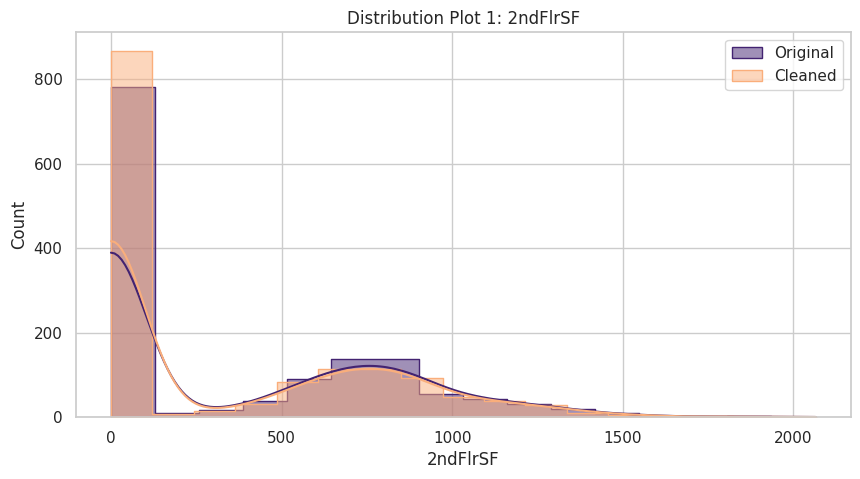

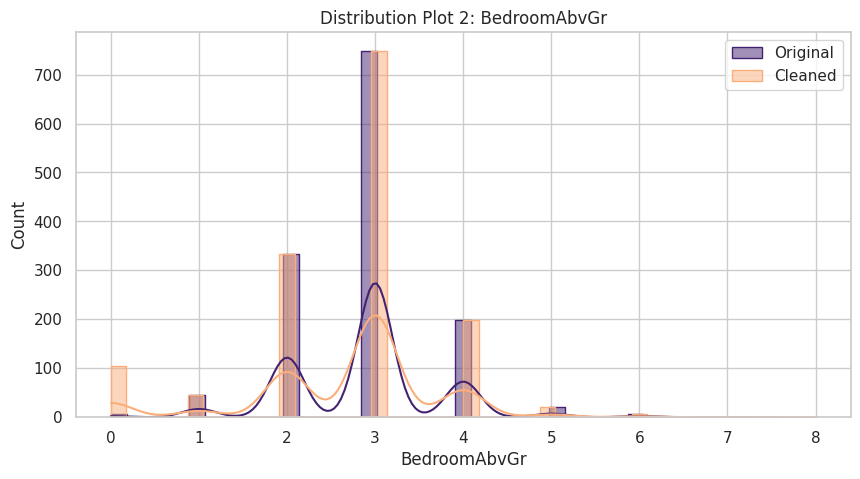

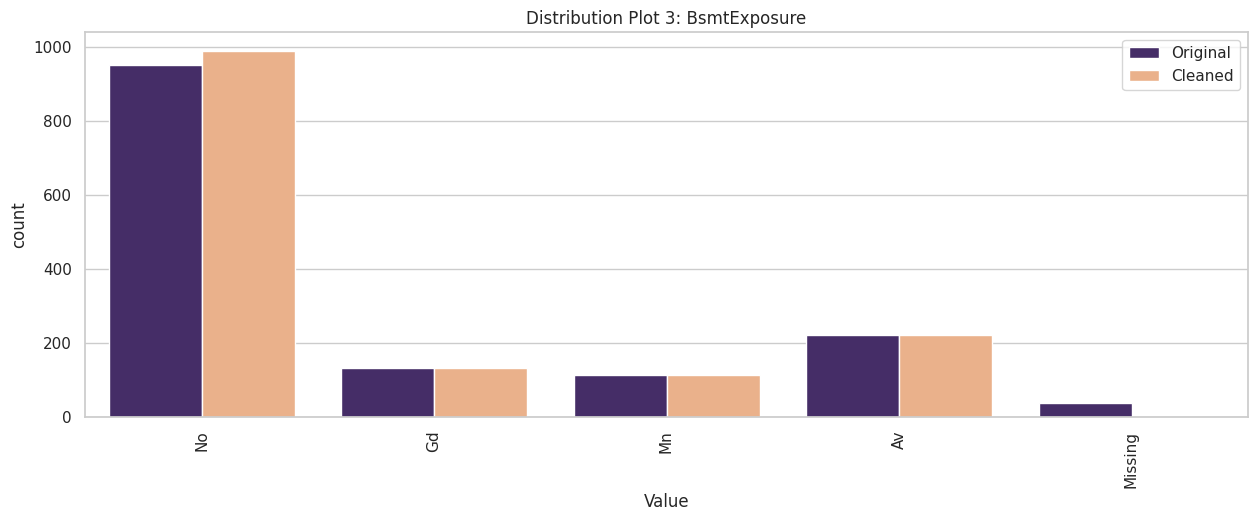

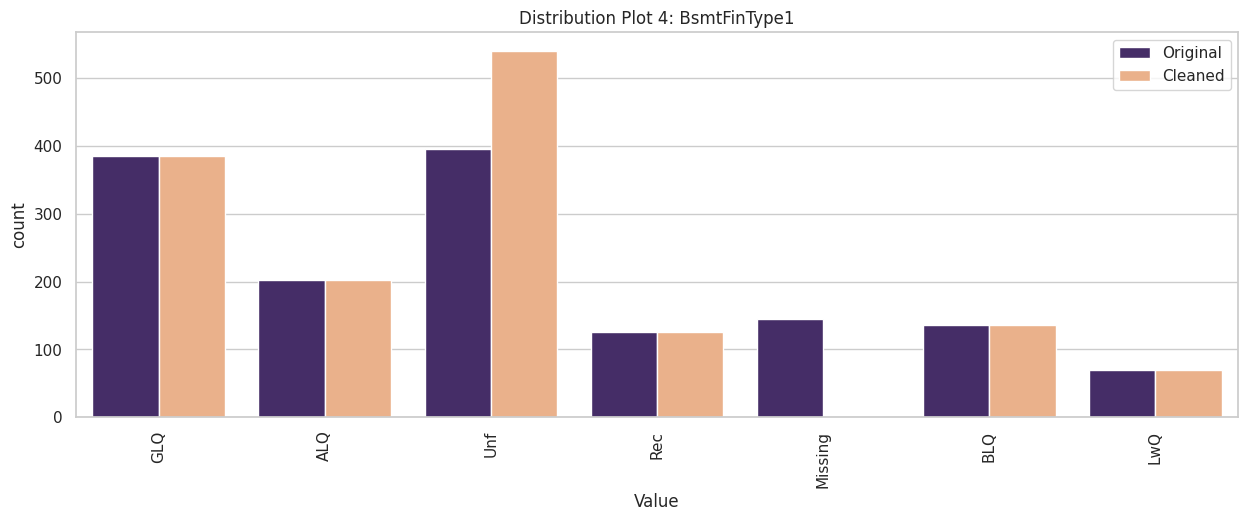

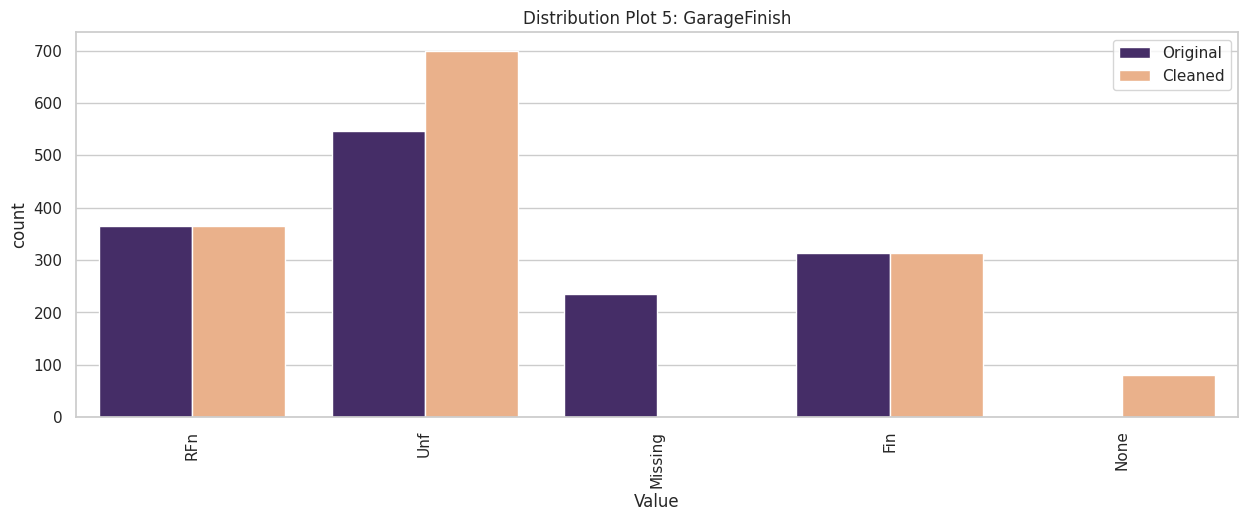

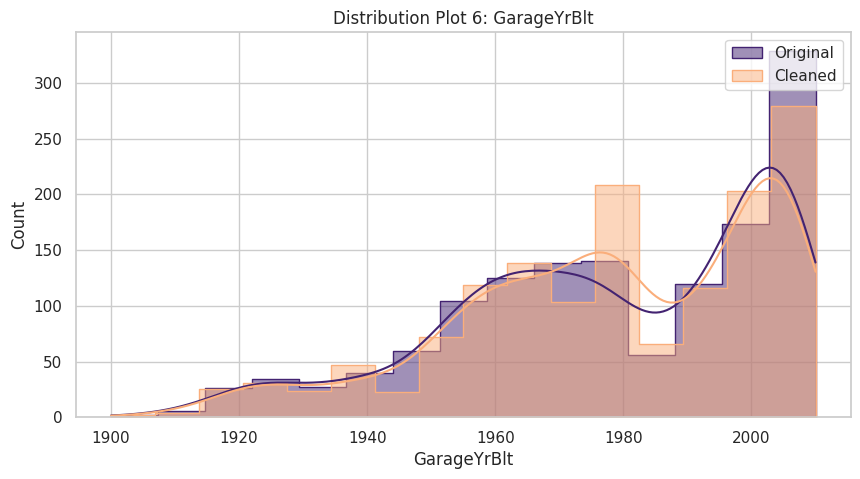

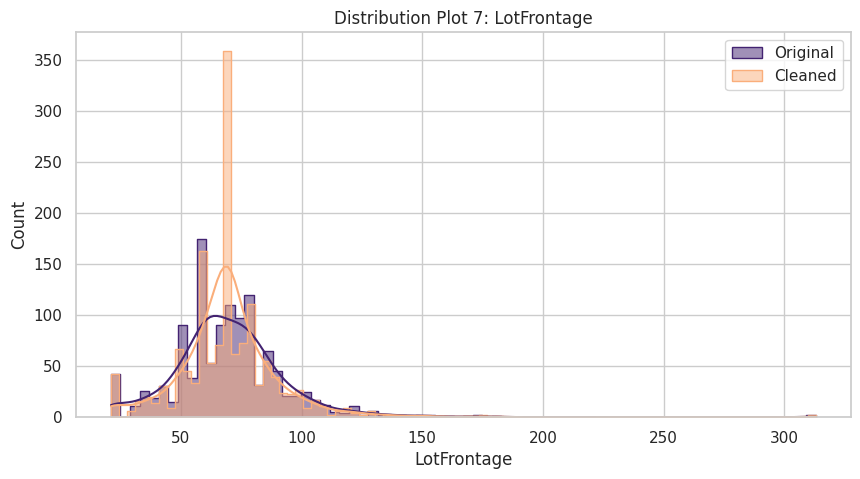

In [75]:
DataCleaningEffect(df_original=df,
                df_cleaned=df_clean,
                variables_applied_with_method=null_variables)

## Push Files to Repo

In [ ]:

# Define the full path (relative to your notebook or script)
cleaned_dir = "../outputs/datasets/cleaned"

# Save the CSV files
train_set.to_csv(f"../outputs/datasets/cleaned/trainSet.csv", index=False)
test_set.to_csv(f"../outputs/datasets/cleaned/testSet.csv", index=False)
df_clean.to_csv(f"../outputs/datasets/cleaned/cleanSet.csv", index=False)

